Baseline model (lag1 only)
MAE: 1884.68
RMSE: 2443.89

Feature-engineered linear regression
MAE: 1231.59
RMSE: 1637.02


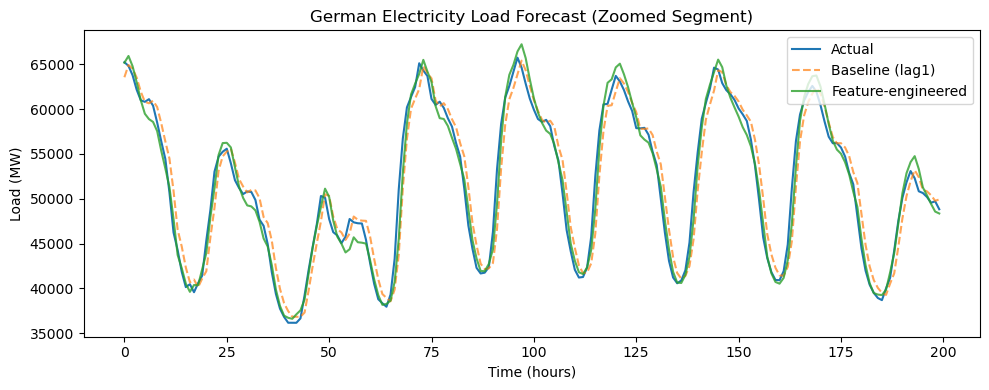

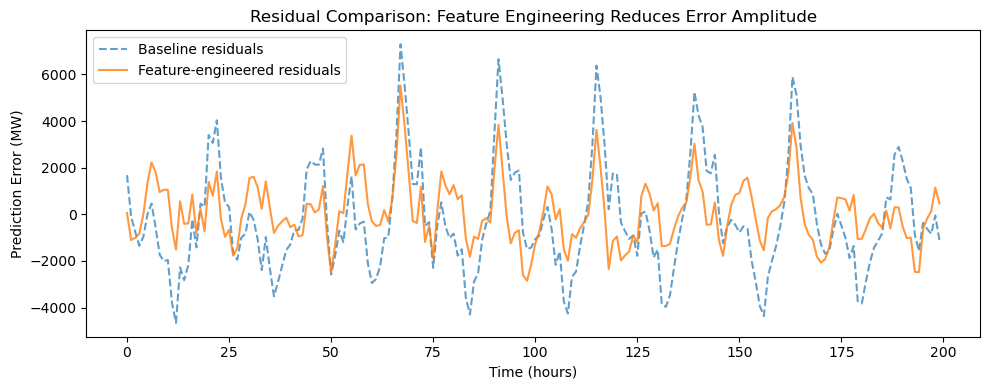

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load dataset from Open Power System Data (OPSD)
url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"
df = pd.read_csv(url, parse_dates=['utc_timestamp'])

# Select German load column and drop missing values
germany_load = df[['utc_timestamp', 'DE_load_actual_entsoe_transparency']].dropna()
germany_load = germany_load.rename(columns={
    'utc_timestamp': 'Date',
    'DE_load_actual_entsoe_transparency': 'Load'
})

# Create lag features: 1 hour, 24 hours (daily), 168 hours (weekly)
germany_load['lag1'] = germany_load['Load'].shift(1)
germany_load['lag24'] = germany_load['Load'].shift(24)
germany_load['lag168'] = germany_load['Load'].shift(168)

# Rolling mean over the past 24 hours
germany_load['roll24'] = germany_load['Load'].rolling(window=24).mean()

# Fourier terms for daily and weekly seasonality
t = np.arange(len(germany_load))
germany_load['sin_daily'] = np.sin(2 * np.pi * t / 24)
germany_load['cos_daily'] = np.cos(2 * np.pi * t / 24)
germany_load['sin_weekly'] = np.sin(2 * np.pi * t / (24 * 7))
germany_load['cos_weekly'] = np.cos(2 * np.pi * t / (24 * 7))

# Drop rows with missing values created by shifting/rolling
germany_load = germany_load.dropna()

# Train-test split (80% train, 20% test)
split_index = int(len(germany_load) * 0.8)
train = germany_load.iloc[:split_index]
test = germany_load.iloc[split_index:]

y_train = train['Load']
y_test = test['Load']

# 1) Baseline model (lag1 only)
X_train_base = train[['lag1']]
X_test_base = test[['lag1']]

baseline_model = LinearRegression()
baseline_model.fit(X_train_base, y_train)
y_pred_base = baseline_model.predict(X_test_base)

mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = mean_squared_error(y_test, y_pred_base, squared=False)

print("Baseline model (lag1 only)")
print("MAE:", round(mae_base, 2))
print("RMSE:", round(rmse_base, 2))
print()

# 2) Feature-engineered model (lags + rolling + Fourier)
feature_cols = [
    'lag1', 'lag24', 'lag168',
    'roll24',
    'sin_daily', 'cos_daily',
    'sin_weekly', 'cos_weekly'
]

X_train_feat = train[feature_cols]
X_test_feat = test[feature_cols]

feat_model = LinearRegression()
feat_model.fit(X_train_feat, y_train)
y_pred_feat = feat_model.predict(X_test_feat)

mae_feat = mean_absolute_error(y_test, y_pred_feat)
rmse_feat = mean_squared_error(y_test, y_pred_feat, squared=False)

print("Feature-engineered linear regression")
print("MAE:", round(mae_feat, 2))
print("RMSE:", round(rmse_feat, 2))

# Visualization: zoomed forecasts and residual comparison
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:200], label='Actual', linewidth=1.5)
plt.plot(y_pred_base[:200], label='Baseline (lag1)', linestyle='--', alpha=0.7)
plt.plot(y_pred_feat[:200], label='Feature-engineered', linestyle='-', alpha=0.8)
plt.title('German Electricity Load Forecast (Zoomed Segment)')
plt.xlabel('Time (hours)')
plt.ylabel('Load (MW)')
plt.legend()
plt.tight_layout()
plt.show()

# Residual comparison
res_base = y_test.values - y_pred_base
res_feat = y_test.values - y_pred_feat

plt.figure(figsize=(10, 4))
plt.plot(res_base[:200], label='Baseline residuals', linestyle='--', alpha=0.7)
plt.plot(res_feat[:200], label='Feature-engineered residuals', linestyle='-', alpha=0.8)
plt.title('Residual Comparison: Feature Engineering Reduces Error Amplitude')
plt.xlabel('Time (hours)')
plt.ylabel('Prediction Error (MW)')
plt.legend()
plt.tight_layout()
plt.savefig('residuals_plot.png', dpi=300)
plt.show()